In [1]:
%reset
import sys
sys.path.append('../../')
import numpy as np
import pandas as pd
import datetime
from tsa import UVariateTimeSeriesClass
from tsa import UVariateTimeSeriesForecaster
from tsa import ProphetForecaster
from tsa import ARIMAForecaster
from tsa import SARIMAForecaster
from tsa import AutoARIMAForecaster
from tsa import LinearForecaster
from tsa import ExponentialSmoothingForecaster
from tsa import GridSearchClass
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
%matplotlib inline
from random import sample

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


##### Read in the data and plot it
###### Do not forget to define frequency and time_format

In [2]:
try:
    ts_univ = pd.read_csv('../../data/AirPassengers.csv', parse_dates=True, index_col='Month', date_parser=lambda dates: pd.datetime.strptime(dates, '%Y-%m'))
    time_format= "%Y-%m" 
    freq= 'MS' 
    
    print ( "====================================\nData: data of shape " + str(ts_univ.shape) + " has been read in." ) 
except IOError as e:
    print("Could not read in the data: {}".format(e))

Data: data of shape (144, 1) has been read in.


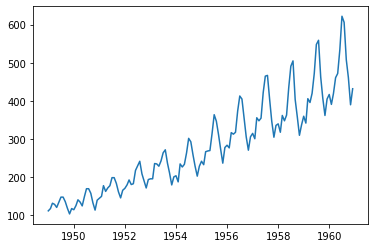

In [3]:
plt.plot(ts_univ)

##### Gain deep insights into time series data
* Instantiate UVariateTimeSeriesClass:
   * time series will be resampled
   * each new value will be either filed foreward (method='ffill') or interpolated (method='interp1d')

In [ ]:
uvts_cls = UVariateTimeSeriesClass(ts_df=ts_univ, time_format=time_format, freq=freq, fill_method='ffill')
plt.plot(uvts_cls.ts_df)

##### Stationarity
###### Look at the moving average and the moving variance, for example, using the window size 12

In [ ]:
plt.plot(uvts_cls.ts_df)
plt.plot(uvts_cls.rolling_mean(window=12))

In [ ]:
plt.plot(uvts_cls.rolling_variance(window=12))

###### Neither mean nor variance stationarity is to be observed

##### Decompose time series to gain more insights. These time series data looks more like multiplicative. Let's just try this out.

In [ ]:
uvts_cls.ts_decompose(params={'model':'multiplicative'})

##### Clear trend is to be observed. Seasonality is also to be seen. We have got 12 years data and we see clear yearly seasonality. Let's now look at only, say, tree years data.

In [ ]:
uvts_cls.ts_decompose(params={'model':'multiplicative',
                              'from': '1950-01',
                               'to' : '1953-01'})

##### Additionally, seasonality can be observed within each year (quarterly). Before starting to fit a model to this time series data, we need to do some steps.

##### No variance stationarity hence transform time series using log transform.

In [ ]:
uvts_cls.ts_transform('log10')
plt.plot(uvts_cls.ts_df)

##### Now again look at moving average and moving variance

In [ ]:
plt.plot(uvts_cls.ts_df)
plt.plot(uvts_cls.rolling_mean(window=12))

In [ ]:
#plt.plot(uvts_cls.ts_df)
plt.plot(uvts_cls.rolling_variance(window=12))

###### Moving average has still a trend, however standard deviation shows now completely different behaviour - it is almost stable.

##### Now we are sure, additive decomposition is the correct one. So let's use STL decomposition.

In [ ]:
uvts_cls.ts_stl_decompose(params={'period':12})

##### Differencing of time series: Looks like we are dealing with a linear trend and yearly seasonality given monthly data. So, let's look at 1st order differencing and seasonal differenting with the interval 12

In [ ]:
plt.plot(uvts_cls.difference(lag=1))

###### Trend is no more to be observed.

In [ ]:
plt.plot(uvts_cls.difference(lag=12))

###### Seasonal effects have almost disapeared.

##### Test for stationarity

In [ ]:
uvts_cls.test_adf()

In [ ]:
uvts_cls.test_kpss()

##### Let's look at ACF and PACF

In [ ]:
uvts_cls.acf_plots()

In [ ]:
uvts_cls.pacf_plots()

##### Modelling
###### Please use only one type of a forecaster. Underneeth are given SARIMAForecaster, AutoARIMAForecaster, ExponentialSmoothingForecaster and UVariateTimeSeriesForecaster. After initializing a forcaster please jump to Fit and Diagnose section

##### Seasonal ARIMA Forecaster

In [ ]:
tsf_obj = SARIMAForecaster(ts_df=ts_univ, time_format=time_format, freq=freq, fill_method='ffill',
                           n_test=12, n_val=6,
                           trend='linear',
                           order=(2, 1, 2), #p, d, q
                           s_order=(0, 1, 1, 12)) # P, D, Q and number of seasonal periods

##### Auto ARIMA Forecaster

In [4]:
tsf_obj = AutoARIMAForecaster(ts_df=ts_univ, time_format=time_format, freq=freq, n_test=12, n_val=6,
                              trend='linear',
                              max_p=3,
                              max_q=2,
                              seasonal=True,
                              max_P=3,
                              max_Q=3,
                              seasonal_periods=12)

2019-10-25 10:16:48,748 | uvts_cls | INFO : Received time series data of range: 1949-01-01 00:00:00 - 1960-12-01 00:00:00 and shape: (144, 1)
2019-10-25 10:16:48,758 | uvts_cls | INFO : Time series resampled at frequency: <MonthBegin>. New shape of the data: (144, 1)
2019-10-25 10:16:48,760 | uvts_cls | INFO : Using time series data of range: 1949-01-01 00:00:00 - 1960-12-01 00:00:00 and shape: (144, 1)


##### ExponentialSmoothing Forecaster

In [5]:
tsf_obj = ExponentialSmoothingForecaster(ts_df=ts_univ, time_format=time_format, freq=freq, n_test=12, n_val=6,
                                         trend='additive',
                                         seasonal=True,
                                         seasonal_periods=12,
                                         smoothing_level=0.9, # alpha
                                         smoothing_slope=0.8, # beta
                                         smoothing_seasonal=0.29) #gamma

2019-10-25 10:16:51,348 | uvts_cls | INFO : Received time series data of range: 1949-01-01 00:00:00 - 1960-12-01 00:00:00 and shape: (144, 1)
2019-10-25 10:16:51,357 | uvts_cls | INFO : Time series resampled at frequency: <MonthBegin>. New shape of the data: (144, 1)
2019-10-25 10:16:51,360 | uvts_cls | INFO : Using time series data of range: 1949-01-01 00:00:00 - 1960-12-01 00:00:00 and shape: (144, 1)


##### UVariateTimeSeriesForecaster
###### This forecaster will fit all types of models you specify using parameter forecasters. Supported ones are 'prophet', 'linear', 'auto_arima', 'arima, 'sarima', 'exponential smoothing' and 'dlm'. Please referre to the documentation of each forecaster (.py files)

In [6]:
tsf_obj = UVariateTimeSeriesForecaster(forecasters=['auto_arima', 'sarima', 'exponential smoothing', 'prophet'],
                                       ts_df=ts_univ, time_format=time_format, freq=freq, n_test=24, n_val=12,
                                       trend='linear',
                                       seasonal_periods=12,
                                       seasonal=True,
                                       max_p=3, # auto_arima
                                       max_q=3, # auto_arima
                                       max_Q=3, # auto_arima
                                       max_P=3, # auto_arima
                                       order = (2,1,2), # sarima
                                       s_order = (0, 1, 1, 12), # sarima
                                       optimized=True, # exp. smoothing
                                       damped=True, # exp. smoothing
                                       use_brute=True, # exp. smoothing
                                       prophet_interval_width=0.95, # prophet
                                       yearly_seasonality=True, # prophet
                                       weekly_seasonality=False, # prophet
                                       monthly_seasonality=False, # prophet
                                       quarterly_seasonality=False, # prophet
                                       daily_seasonality=False, # prophet
                                       weekend_seasonality=False, # prophet
                                       changepoint_prior_scale=0.001, # prophet
                                       consider_holidays=False, # prophet
                                       diagnose=False) # prophet                                    

2019-10-25 10:16:54,925 | uvts_cls | INFO : Received time series data of range: 1949-01-01 00:00:00 - 1960-12-01 00:00:00 and shape: (144, 1)
2019-10-25 10:16:54,934 | uvts_cls | INFO : Time series resampled at frequency: <MonthBegin>. New shape of the data: (144, 1)
2019-10-25 10:16:54,936 | uvts_cls | INFO : Using time series data of range: 1949-01-01 00:00:00 - 1960-12-01 00:00:00 and shape: (144, 1)


##### Fit and Diagnose

2019-10-25 10:16:56,273 | prophet | INFO : Trying to fit the Prophet model....
2019-10-25 10:16:56,302 | numexpr.utils | INFO : NumExpr defaulting to 8 threads.
2019-10-25 10:16:56,387 | prophet | INFO : Model successfully fitted to the data!
2019-10-25 10:16:56,389 | prophet | INFO : Computing fitted values and residuals...
2019-10-25 10:16:58,062 | prophet | INFO : Done.
2019-10-25 10:16:58,067 | SARIMA | INFO : Trying to fit the sarima model....
2019-10-25 10:16:58,812 | SARIMA | INFO : Time elapsed: 0.7443134784698486 sec.
2019-10-25 10:16:58,814 | SARIMA | INFO : Model successfully fitted to the data!
2019-10-25 10:16:58,815 | SARIMA | INFO : Computing fitted values and residuals...
2019-10-25 10:16:58,817 | SARIMA | INFO : Done.
2019-10-25 10:16:58,824 | AutoARIMA | INFO : Trying to fit the Auto ARIMA model....
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=-487.632, BIC=-472.309, Fit time=0.432 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=-4

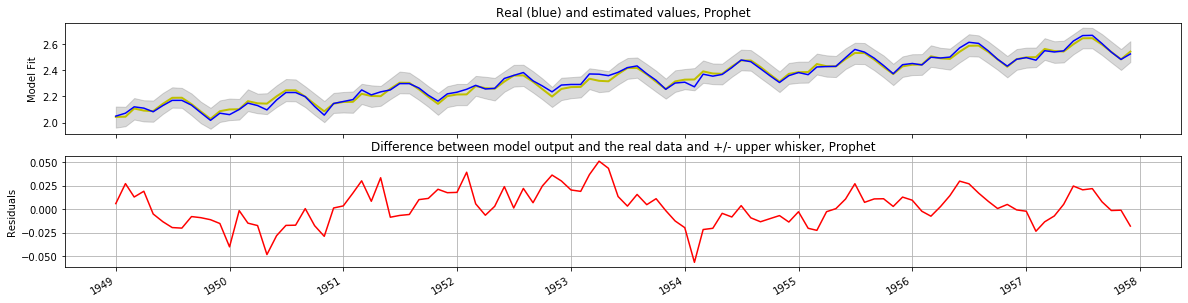

Residuals statistics
count    108.000000
mean       0.007453
std        0.240940
min       -1.348453
25%       -0.011395
50%       -0.000446
75%        0.012340
max        2.049218
dtype: float64


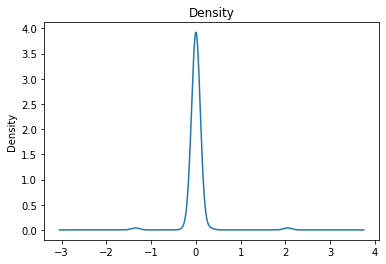

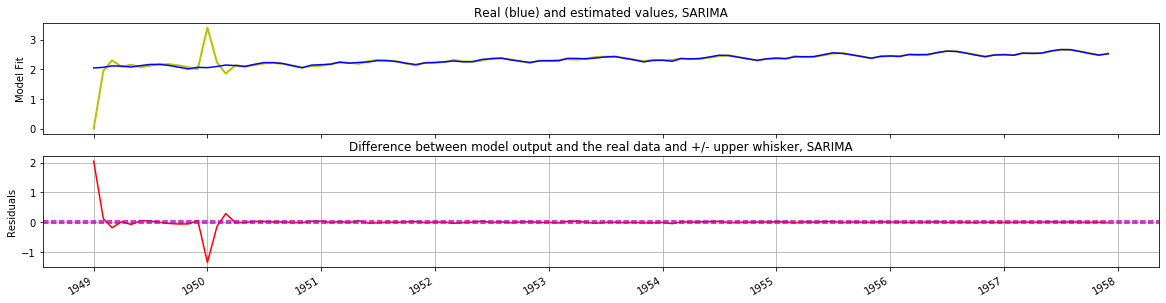

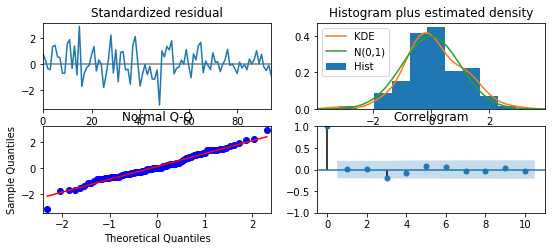

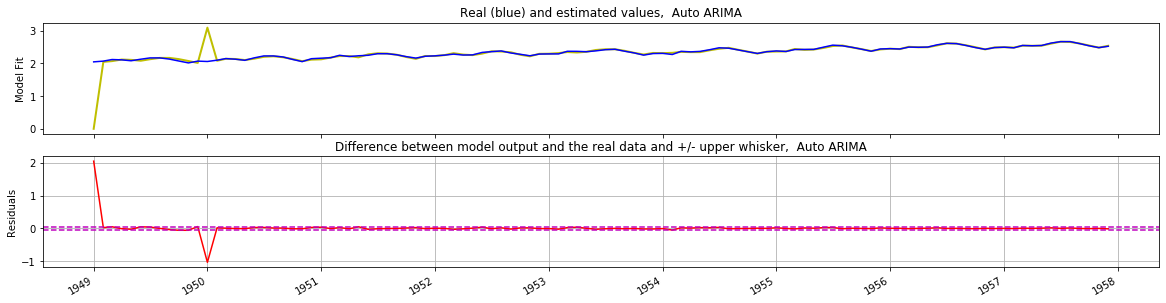

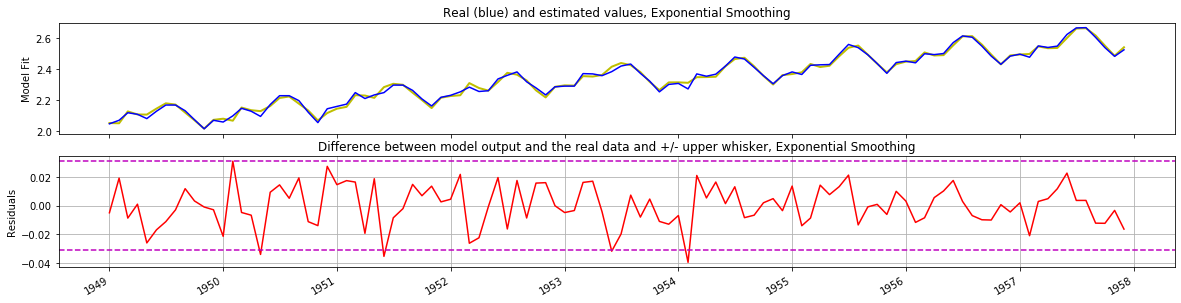

In [7]:
tsf_obj.ts_transform(transform='log10').ts_fit(suppress=True).ts_diagnose() 

In [ ]:
tsf_obj.plot_residuals()

##### Test the model on test data if it was generated through n_test parameter

2019-10-25 10:17:32,488 | prophet | INFO : Evaluating the fitted Prophet model on the test data...
2019-10-25 10:17:34,108 | prophet | INFO : RMSE on test data: 0.04929715749352849


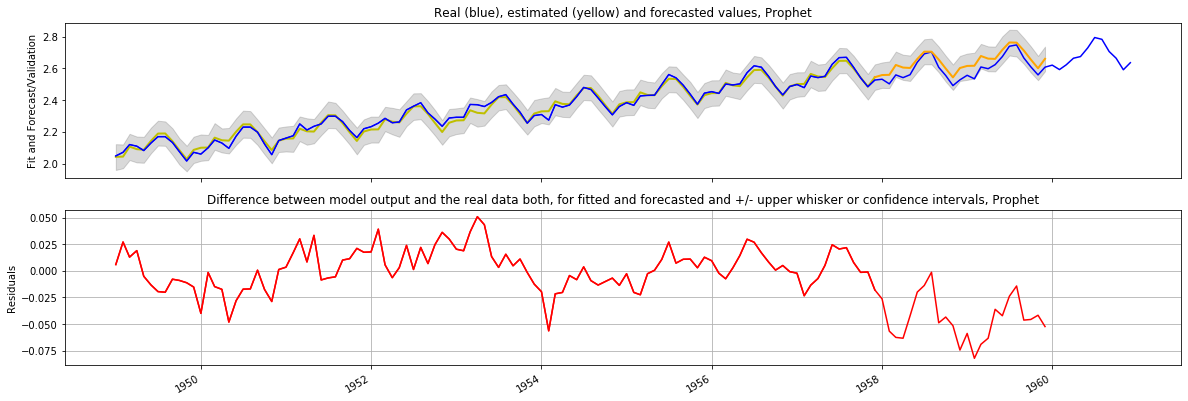

2019-10-25 10:17:34,458 | SARIMA | INFO : Evaluating the fitted SARIMA model on the test data...
2019-10-25 10:17:34,481 | SARIMA | INFO : RMSE on test data: 0.026896657871848847


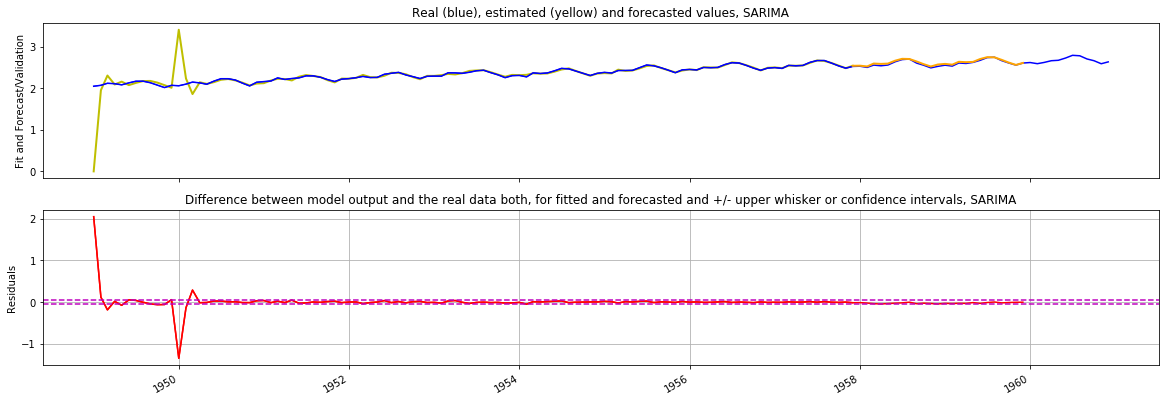

2019-10-25 10:17:34,789 | AutoARIMA | INFO : Evaluating the fitted ARIMA model on the test data...
2019-10-25 10:17:34,807 | AutoARIMA | INFO : RMSE on test data: 0.021576563157381233


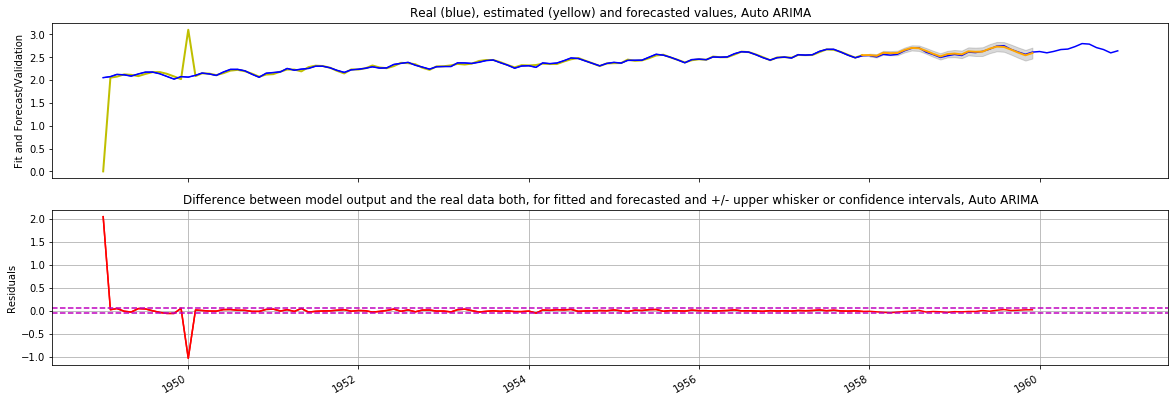

2019-10-25 10:17:35,149 | ExpSmoothing | INFO : Evaluating the fitted model on the test data...
2019-10-25 10:17:35,161 | ExpSmoothing | INFO : RMSE on test data: 0.03460833258163754


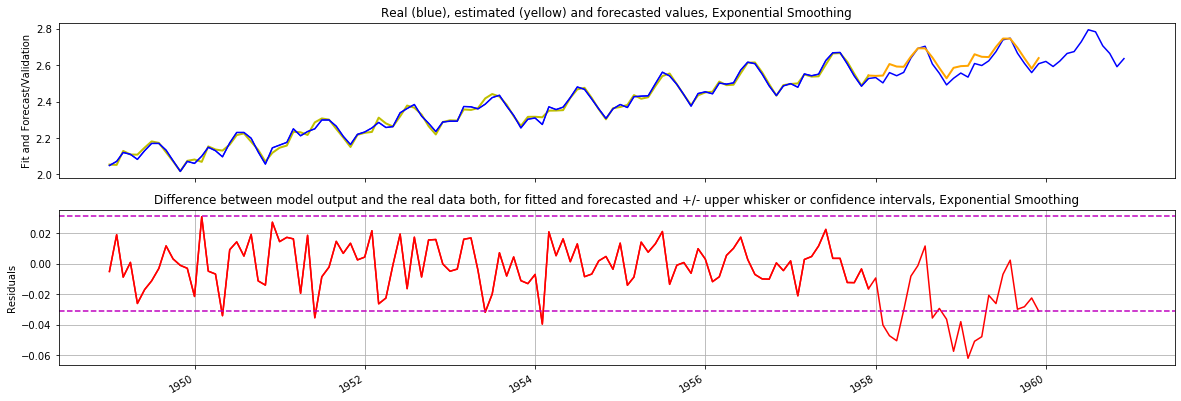

2019-10-25 10:17:35,491 | uvtsf | INFO : The best model selected as: AutoARIMAForecaster


In [8]:
tsf_obj.ts_test(show_plot=True)

##### Validate the model on validation data if it was generated through n_val parameter

2019-10-25 10:17:40,412 | AutoARIMA | INFO : Trying to fit the Auto ARIMA model....
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=-629.227, BIC=-612.553, Fit time=5.509 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=-595.608, BIC=-590.050, Fit time=0.181 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=-626.978, BIC=-615.861, Fit time=0.958 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-629.197, BIC=-618.080, Fit time=0.612 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-633.812, BIC=-619.917, Fit time=0.616 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=-604.214, BIC=-593.097, Fit time=0.188 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=-610.549, BIC=-593.874, Fit time=1.959 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=-609.615, BIC=-590.161, Fit time=2.181 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 

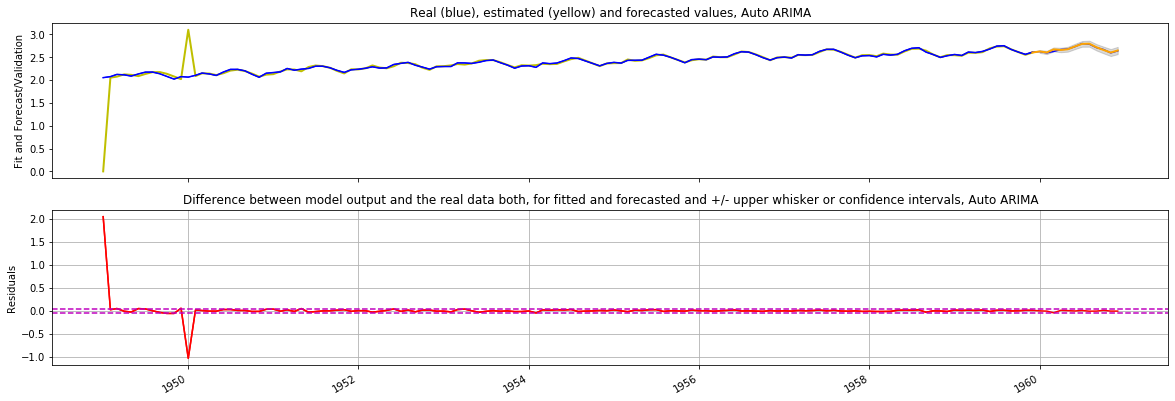

In [9]:
tsf_obj.ts_validate(suppress=True, show_plot=True)

##### Forecast n_forecast steps

2019-10-25 10:18:17,163 | AutoARIMA | INFO : Fitting using all data....
2019-10-25 10:18:17,165 | AutoARIMA | INFO : Trying to fit the Auto ARIMA model....
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=-686.045, BIC=-668.793, Fit time=0.490 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=-651.366, BIC=-645.615, Fit time=0.094 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=-687.816, BIC=-676.316, Fit time=0.333 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-691.014, BIC=-679.513, Fit time=0.278 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=-688.513, BIC=-674.137, Fit time=0.432 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=-666.216, BIC=-657.590, Fit time=0.126 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=-696.855, BIC=-682.479, Fit time=1.739 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=-673.892, BIC=-656.641, Fit

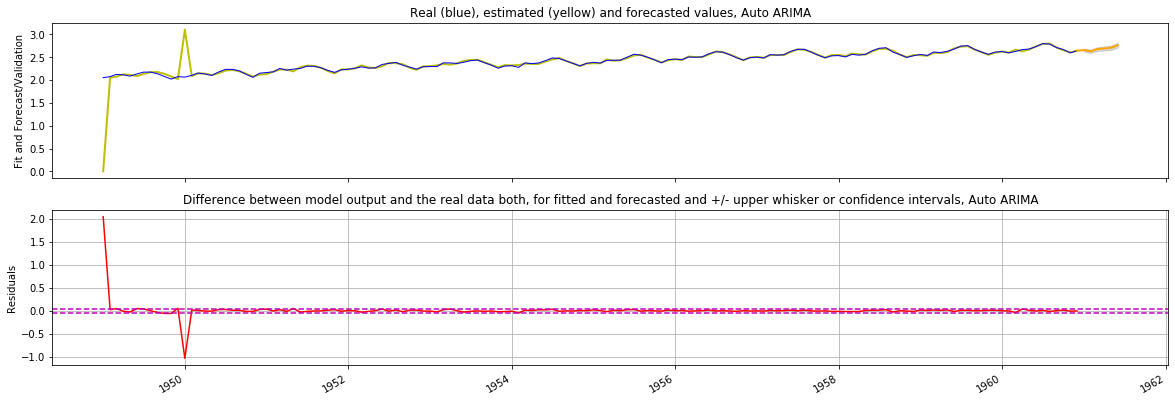

In [10]:
tsf_obj.ts_forecast(n_forecast = 6, suppress=True).plot_forecast()

##### Grid Search - not needed with auto_arima!

In [ ]:
#tsf_obj.ts_transform("log10")
gs = GridSearchClass(forecaster=tsf_obj, hyper_params = {'order': [(4,2,2),(3,2,2)], 's_order': [(1, 1, 1, 12), (1, 0, 1, 12)], 'trend':['linear', 'constant linear']})

In [ ]:
gs.grid_search(suppress=True)

In [ ]:
gs.results